# TASK 1

In [2]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# 1. Define columns and load data
column_list = [
    'age','workclass','fnlwgt','education','education_num',
    'marital_status','occupation','relationship','race','sex',
    'capital_gain','capital_loss','hours_per_week','native_country','income'
]
raw_train = pd.read_csv(
    'adult.data',
    header=None,
    names=column_list,
    sep=',',
    skipinitialspace=True
)
raw_test = pd.read_csv(
    'adult.test',
    header=None,
    names=column_list,
    sep=',',
    skipinitialspace=True,
    skiprows=1
)
raw_test['income'] = raw_test['income'].str.rstrip('.')

# 2. Clean missing values
raw_train.replace('?', pd.NA, inplace=True)
raw_train.dropna(inplace=True)
raw_test.replace('?', pd.NA, inplace=True)
raw_test.dropna(inplace=True)

# 3. One-hot encode categorical predictors
cat_cols = [
    'workclass','education','marital_status','occupation',
    'relationship','race','sex','native_country'
]
features_train = pd.get_dummies(raw_train.drop('income', axis=1), columns=cat_cols)
features_test  = pd.get_dummies(raw_test.drop('income', axis=1), columns=cat_cols)
features_test  = features_test.reindex(columns=features_train.columns, fill_value=0)

# 4. Encode target variable
labels_train = (raw_train['income'] == '>50K').astype(int)
labels_test  = (raw_test['income'] == '>50K').astype(int)

# 5. Train Gaussian Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(features_train, labels_train)

# 6. Predict probabilities for the positive class
positive_probs = nb_model.predict_proba(features_test)[:, 1]

# 7. Evaluate at default threshold (0.5)
default_thresh = 0.5
preds_default = (positive_probs >= default_thresh).astype(int)
print("Default (0.5) →",
      f"Acc={accuracy_score(labels_test, preds_default):.3f}",
      f"Prec={precision_score(labels_test, preds_default):.3f}",
      f"Rec={recall_score(labels_test, preds_default):.3f}",
      f"F1={f1_score(labels_test, preds_default):.3f}")

# 8. Evaluate at tuned threshold (0.3)
tuned_thresh = 0.3
preds_tuned = (positive_probs >= tuned_thresh).astype(int)
print(f"Tuned ({tuned_thresh}) →",
      f"Acc={accuracy_score(labels_test, preds_tuned):.3f}",
      f"Prec={precision_score(labels_test, preds_tuned):.3f}",
      f"Rec={recall_score(labels_test, preds_tuned):.3f}",
      f"F1={f1_score(labels_test, preds_tuned):.3f}")

# 9. ROC-AUC (threshold-independent)
print("ROC-AUC:", roc_auc_score(labels_test, positive_probs))

# 10. 10-fold cross-validation on training data
cv_scores = cross_val_score(nb_model, features_train, labels_train, cv=10, scoring='accuracy')
print("CV acc: mean", round(cv_scores.mean(),3),
      "range", round(cv_scores.min(),3), "-", round(cv_scores.max(),3))

# 11. Null-accuracy baseline
null_accuracy = labels_test.value_counts().max() / len(labels_test)
print("Null acc:", round(null_accuracy,3))

# 12. Detailed report at tuned threshold
print(f"\nClassification Report (threshold={tuned_thresh}):")
print(classification_report(labels_test, preds_tuned, target_names=['<=50K','>50K']))


Default (0.5) → Acc=0.789 Prec=0.648 Rec=0.306 F1=0.416
Tuned (0.3) → Acc=0.788 Prec=0.640 Rec=0.308 F1=0.416
ROC-AUC: 0.8256077631328511
CV acc: mean 0.789 range 0.78 - 0.798
Null acc: 0.754

Classification Report (threshold=0.3):
              precision    recall  f1-score   support

       <=50K       0.81      0.94      0.87     11360
        >50K       0.64      0.31      0.42      3700

    accuracy                           0.79     15060
   macro avg       0.72      0.63      0.64     15060
weighted avg       0.77      0.79      0.76     15060



# TASK 2

Dataset shape: (1728, 7)

Sample records:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc 

Class frequencies:
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64 



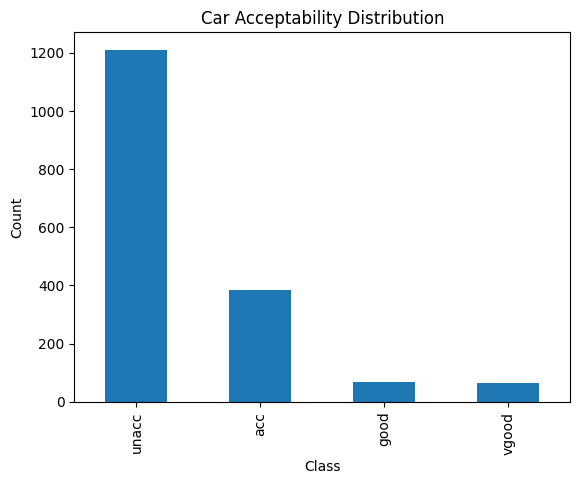


=== Gini Tree ===
Accuracy         : 0.974
Macro Precision  : 0.955
Macro Recall     : 0.941
Macro F1-Score   : 0.945

Confusion Matrix:
[[ 71   2   4   0]
 [  0  14   0   0]
 [  1   0 241   0]
 [  2   0   0  11]]

Classification Report:
              precision    recall  f1-score   support

         acc       0.96      0.92      0.94        77
        good       0.88      1.00      0.93        14
       unacc       0.98      1.00      0.99       242
       vgood       1.00      0.85      0.92        13

    accuracy                           0.97       346
   macro avg       0.95      0.94      0.95       346
weighted avg       0.97      0.97      0.97       346


=== Entropy Tree ===
Accuracy         : 0.991
Macro Precision  : 0.965
Macro Recall     : 0.974
Macro F1-Score   : 0.968

Confusion Matrix:
[[ 75   2   0   0]
 [  0  14   0   0]
 [  0   0 242   0]
 [  1   0   0  12]]

Classification Report:
              precision    recall  f1-score   support

         acc       0.99      

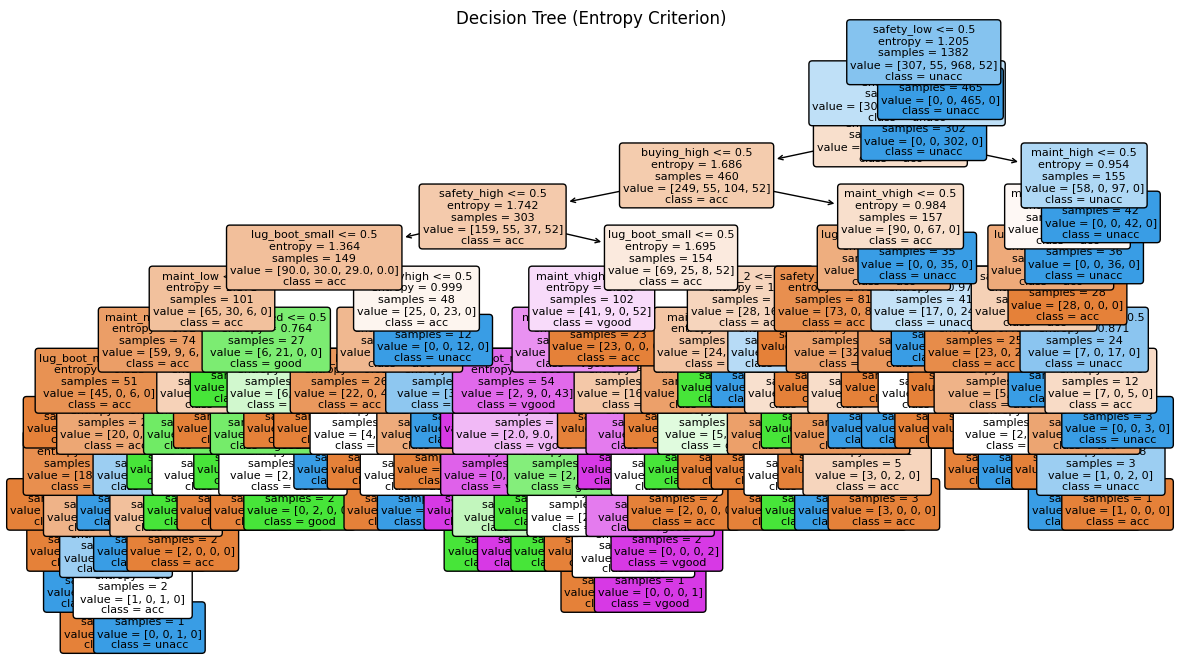

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1. Load data
columns = [
    'buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'
]
data = pd.read_csv('car.data', header=None, names=columns)

# 2. Quick EDA
print("Dataset shape:", data.shape)
print("\nSample records:")
print(data.head(), "\n")
print("Class frequencies:")
print(data['class'].value_counts(), "\n")

# Optional bar plot
data['class'].value_counts().plot(
    kind='bar',
    title='Car Acceptability Distribution'
)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 3. Prepare features & target
features = pd.get_dummies(data.drop('class', axis=1))
labels   = data['class']

# 4. Split into train/test (80/20, stratified)
X_tr, X_te, y_tr, y_te = train_test_split(
    features, labels,
    test_size=0.20,
    random_state=42,
    stratify=labels
)

# 5. Instantiate two trees
tree_gini    = DecisionTreeClassifier(criterion='gini',    random_state=42)
tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)

tree_gini.fit(X_tr, y_tr)
tree_entropy.fit(X_tr, y_tr)

# 6. Define assessment function
def assess_model(name, model, X_eval, y_eval):
    preds = model.predict(X_eval)
    print(f"\n=== {name} Tree ===")
    print(f"Accuracy         : {accuracy_score(y_eval, preds):.3f}")
    print(f"Macro Precision  : {precision_score(y_eval, preds, average='macro'):.3f}")
    print(f"Macro Recall     : {recall_score(y_eval, preds, average='macro'):.3f}")
    print(f"Macro F1-Score   : {f1_score(y_eval, preds, average='macro'):.3f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_eval, preds))
    print("\nClassification Report:")
    print(classification_report(y_eval, preds))

# 7. Evaluate both
assess_model("Gini",    tree_gini,    X_te, y_te)
assess_model("Entropy", tree_entropy, X_te, y_te)

# 8. (Optional) Plot the entropy-based tree
plt.figure(figsize=(14, 8))
plot_tree(
    tree_entropy,
    feature_names=features.columns,
    class_names=tree_entropy.classes_,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree (Entropy Criterion)")
plt.show()


# TASK 3

In [3]:
# 1. Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

# 2. Read the data
diabetes_df = pd.read_csv('Diabetes.csv')

# 3. Split into features and label
features = diabetes_df.drop('Outcome', axis=1)
label    = diabetes_df['Outcome']

# 4. Create a 90/10 stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, label,
    test_size=0.10,
    random_state=42,
    stratify=label
)

# 5. Train the baseline Decision Tree
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train, y_train)

# 6. Evaluate the baseline model
base_preds = base_tree.predict(X_test)
print("Baseline Decision Tree Performance on Test Set")
print("------------------------------------------------")
print(f"Accuracy : {accuracy_score(y_test, base_preds):.3f}")
print(f"Precision: {precision_score(y_test, base_preds):.3f}")
print(f"Recall   : {recall_score(y_test, base_preds):.3f}")
print(f"F1-Score : {f1_score(y_test, base_preds):.3f}")
print("\nClassification Report:\n", classification_report(y_test, base_preds))

# 7. Define hyperparameter search space
search_params = {
    'max_depth':        [None, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}

# 8. Grid search with 5-fold CV
param_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=search_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
param_search.fit(X_train, y_train)

print("\nBest Hyperparameters Found:")
print(param_search.best_params_)

# 9. Train & evaluate the tuned tree
tuned_tree = param_search.best_estimator_
tuned_preds = tuned_tree.predict(X_test)

print("\nOptimized Decision Tree Performance on Test Set")
print("------------------------------------------------")
print(f"Accuracy : {accuracy_score(y_test, tuned_preds):.3f}")
print(f"Precision: {precision_score(y_test, tuned_preds):.3f}")
print(f"Recall   : {recall_score(y_test, tuned_preds):.3f}")
print(f"F1-Score : {f1_score(y_test, tuned_preds):.3f}")
print("\nClassification Report:\n", classification_report(y_test, tuned_preds))


Baseline Decision Tree Performance on Test Set
------------------------------------------------
Accuracy : 0.740
Precision: 0.640
Recall   : 0.593
F1-Score : 0.615

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        50
           1       0.64      0.59      0.62        27

    accuracy                           0.74        77
   macro avg       0.71      0.71      0.71        77
weighted avg       0.74      0.74      0.74        77


Best Hyperparameters Found:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Optimized Decision Tree Performance on Test Set
------------------------------------------------
Accuracy : 0.779
Precision: 0.708
Recall   : 0.630
F1-Score : 0.667

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.71      0.63      0.67        27

    accuracy                        